# Code for Image Extractor

*** Import/Install Necessary Libraries and Load Image***


! apt install tesseract-ocr
! apt install libtesseract-dev

!pip install Pillow
!pip install opencv-python
!pip install pytesseract==0.3.9
!pip install tesseract


In [1]:
import numpy as np
import cv2
import pytesseract
import re
import matplotlib.pyplot as plt

from pytesseract import Output


In [2]:
# pytessercat
#pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

In [38]:
# read image

img = cv2.imread('images/large-receipt-image-dataset-SRD/1005-receipt.jpg', cv2.IMREAD_GRAYSCALE)

*** Definition for Extraction Function ***

In [39]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [40]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [33]:
def receipt_total_extractor(image):

  # Code to detect text boxes
  config = ('-l eng --oem 1 --psm 3')
  d = pytesseract.image_to_data(image, output_type=Output.DICT)
  n_boxes = len(d['level'])
  boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
  for i in range(n_boxes):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
      boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

  # Stores unmodified output as string from Tesseract OCR processing
  extracted_text = pytesseract.image_to_string(image)

  # Code to extract the total amount from a receipt by returning the greatest amount 
  amounts = re.findall(r'\d+\.\d{2}\b', extracted_text)
  floats = [float(amount) for amount in amounts]
  unique = list(dict.fromkeys(floats))
  
  return unique

In [41]:
total = receipt_total_extractor(img)

print(total)

[40.0, 34.0, 5.0, 167.0, 179.94, 33.4, 36.74]


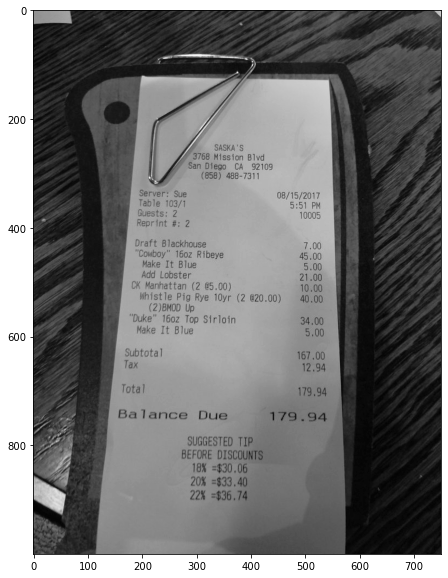

In [42]:
plot_gray(img)

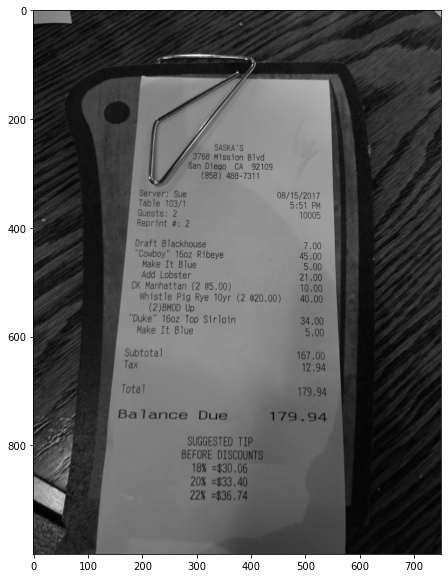

In [43]:
plot_rgb(img)

# Diego Look, the function is right here 

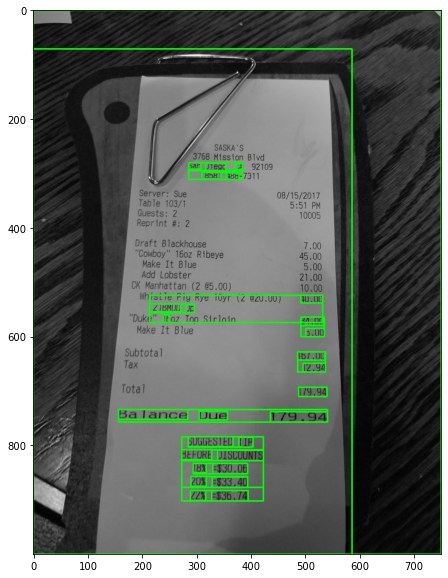

In [44]:
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

*** Code for Cropping ***

In [45]:
import numpy as np
import cv2

from skimage.filters import threshold_local
from PIL import Image

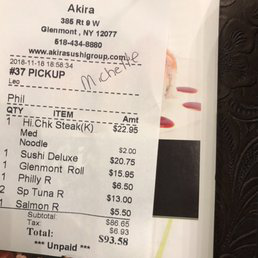

In [13]:

# Sample file out of the dataset
file_name = 'images/large-receipt-image-dataset-SRD/1006-receipt.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [14]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [15]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

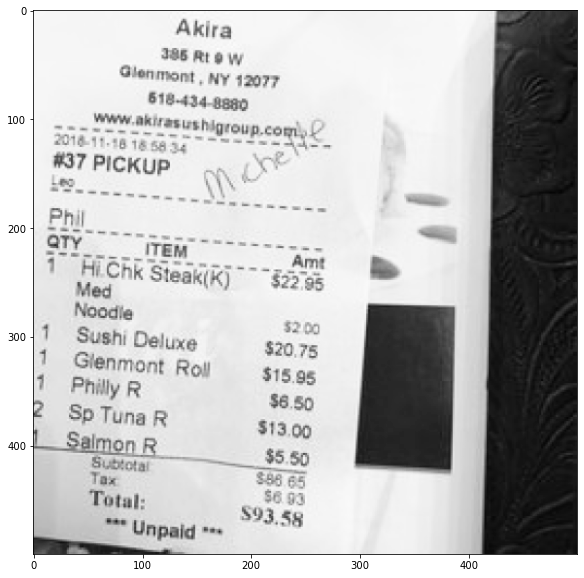

In [16]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

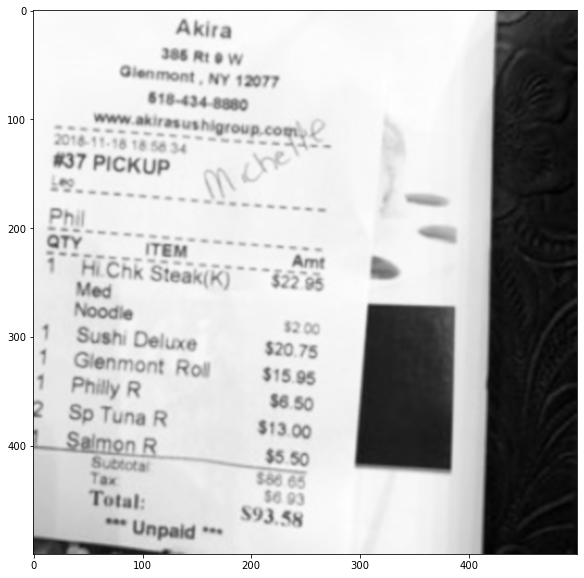

In [17]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

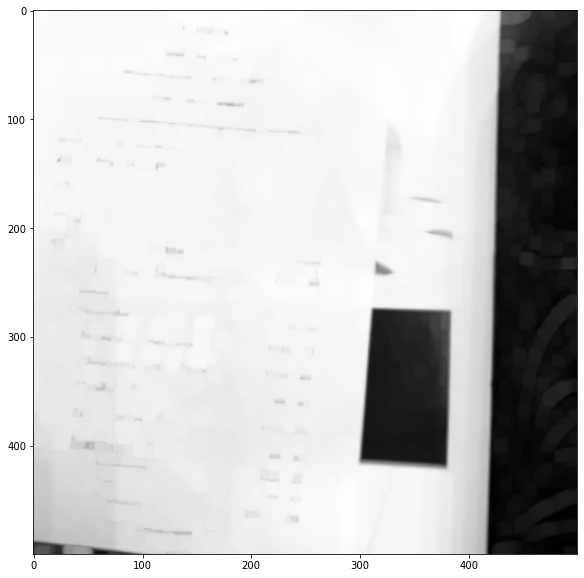

In [18]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

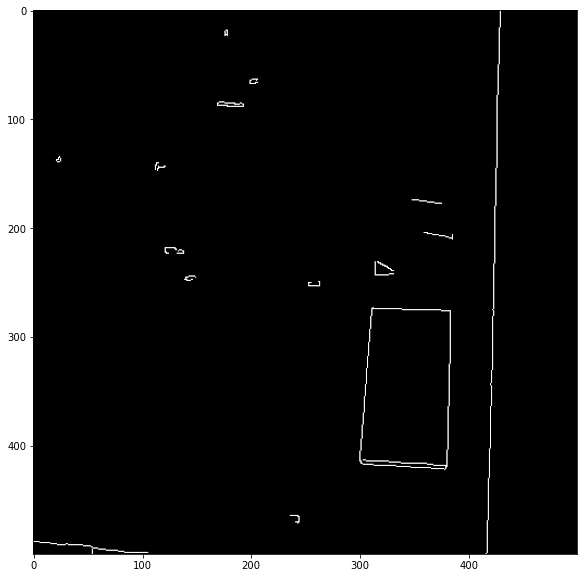

In [19]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)


#edged = cv2.Canny(blurred, 100, 200, apertureSize=3)
#plot_gray(edged)

In [ ]:
cv2.__version__

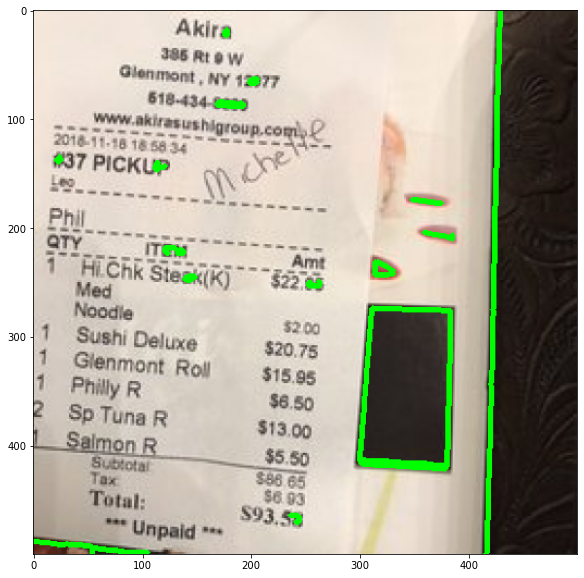

In [20]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

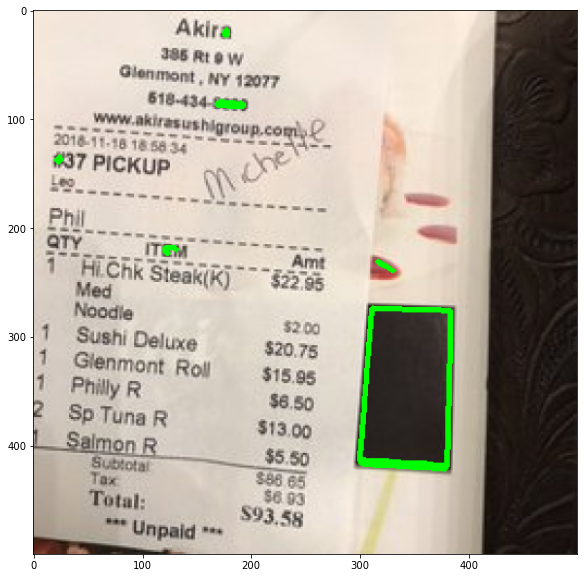

In [21]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [22]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [23]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [24]:
get_receipt_contour(largest_contours)

array([[[312, 273]],

       [[300, 414]],

       [[378, 422]],

       [[383, 276]]], dtype=int32)

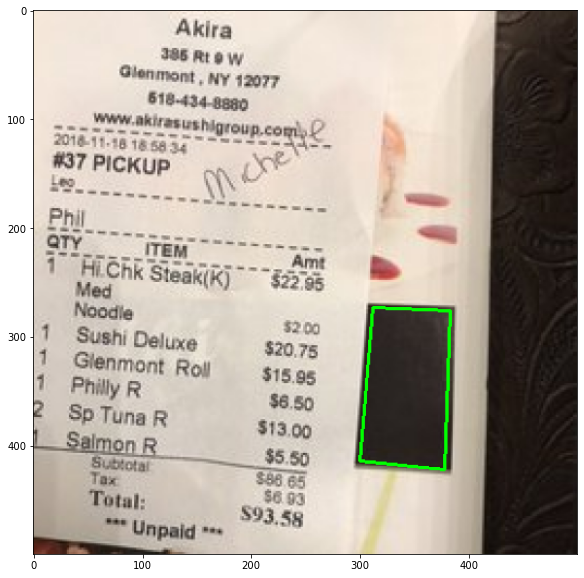

In [25]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [26]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [27]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

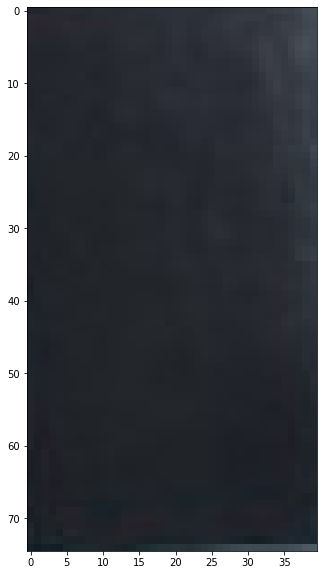

In [28]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [29]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

In [ ]:
result = bw_scanner(scanned)
plot_gray(result)